# Data Preparation
Hourly Temperature readings were provided from **1st Jan, 1989 to 1st Jan, 2018**.

A huge chunk of readings were **missing** in the year **1994** and hence all readings before 1995 were discarded.
Any of the other missing readings were interpolated linearly.

Windows of **2 weeks** were selected and formed as inputs (features) for the XGBoost regression model.
Using these, it was found that predictions for **5 days** in the future were **greatly accurate**.

The inputs were labeled so that the they will have the date indices of the values they are trying to predict i.e. the temperature 5 days into the future and this was saved into a **csv format** for model training and evaluations.

In [2]:
import sqlite3
import pandas as pd
import datetime

## Reading data given by IMD

In [3]:
con = sqlite3.connect('Station_43057.db')
with con:
    df = pd.read_sql('SELECT * FROM Data', con, parse_dates="DateTime", coerce_float=True, index_col="DateTime")
df

,Temp
DateTime,
1989-01-01 01:00:00,21.7
1989-01-01 02:00:00,21.4
1989-01-01 03:00:00,21.6
1989-01-01 04:00:00,21.5
1989-01-01 05:00:00,21.3
...,...
2017-12-31 20:00:00,22.1
2017-12-31 21:00:00,21.7
2017-12-31 22:00:00,21.2


## Interpolating all missing data and discarding data older than 1995

In [4]:
df = df.loc['1989-01-01 01:00':'2018-01-01 00:00'].resample('H').mean().interpolate(method='linear', limit_direction='forward')
df = df['1995-01-01 01:00':'2018-01-01 00:00']
df

,Temp
DateTime,
1995-01-01 01:00:00,26.067091
1995-01-01 02:00:00,26.067384
1995-01-01 03:00:00,26.067677
1995-01-01 04:00:00,26.067970
1995-01-01 05:00:00,26.068263
...,...
2017-12-31 20:00:00,22.100000
2017-12-31 21:00:00,21.700000
2017-12-31 22:00:00,21.200000


<AxesSubplot:xlabel='DateTime'>

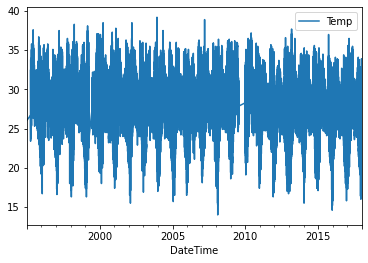

In [5]:
df.plot()

## Creation of input windows of 2 weeks (14*24=336 data input points)

In [6]:
dataframe = df.copy()
datetime_df = df.index.copy()
datetime_df

DatetimeIndex(['1995-01-01 01:00:00', '1995-01-01 02:00:00',
               '1995-01-01 03:00:00', '1995-01-01 04:00:00',
               '1995-01-01 05:00:00', '1995-01-01 06:00:00',
               '1995-01-01 07:00:00', '1995-01-01 08:00:00',
               '1995-01-01 09:00:00', '1995-01-01 10:00:00',
               ...
               '2017-12-31 15:00:00', '2017-12-31 16:00:00',
               '2017-12-31 17:00:00', '2017-12-31 18:00:00',
               '2017-12-31 19:00:00', '2017-12-31 20:00:00',
               '2017-12-31 21:00:00', '2017-12-31 22:00:00',
               '2017-12-31 23:00:00', '2018-01-01 00:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=201624, freq='H')

In [6]:
for i in range(1, 336):
    dataframe.loc[:, f'Temp_{i}'] = dataframe.Temp.shift(-i)
    datetime_df = datetime_df.shift(1)[:-1]
dataframe.dropna(inplace=True)
dataframe

C:\Users\Vedant\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


,Temp,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,Temp_6,Temp_7,Temp_8,Temp_9,...,Temp_326,Temp_327,Temp_328,Temp_329,Temp_330,Temp_331,Temp_332,Temp_333,Temp_334,Temp_335
DateTime,,,,,,,,,,,,,,,,,,,,,
1995-01-01 01:00:00,26.067091,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,...,26.162613,26.162906,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250
1995-01-01 02:00:00,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,...,26.162906,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543
1995-01-01 03:00:00,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,...,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836
1995-01-01 04:00:00,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,...,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129
1995-01-01 05:00:00,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,26.070900,...,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129,26.166422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-17 21:00:00,23.800000,23.600000,22.800000,21.700000,20.600000,20.300000,20.300000,19.900000,19.500000,19.400000,...,26.100000,25.500000,26.000000,26.100000,25.100000,24.400000,23.600000,23.100000,22.700000,22.100000
2017-12-17 22:00:00,23.600000,22.800000,21.700000,20.600000,20.300000,20.300000,19.900000,19.500000,19.400000,19.400000,...,25.500000,26.000000,26.100000,25.100000,24.400000,23.600000,23.100000,22.700000,22.100000,21.700000
2017-12-17 23:00:00,22.800000,21.700000,20.600000,20.300000,20.300000,19.900000,19.500000,19.400000,19.400000,19.700000,...,26.000000,26.100000,25.100000,24.400000,23.600000,23.100000,22.700000,22.100000,21.700000,21.200000


In [7]:
datetime_df

DatetimeIndex(['1995-01-15 00:00:00', '1995-01-15 01:00:00',
               '1995-01-15 02:00:00', '1995-01-15 03:00:00',
               '1995-01-15 04:00:00', '1995-01-15 05:00:00',
               '1995-01-15 06:00:00', '1995-01-15 07:00:00',
               '1995-01-15 08:00:00', '1995-01-15 09:00:00',
               ...
               '2017-12-31 15:00:00', '2017-12-31 16:00:00',
               '2017-12-31 17:00:00', '2017-12-31 18:00:00',
               '2017-12-31 19:00:00', '2017-12-31 20:00:00',
               '2017-12-31 21:00:00', '2017-12-31 22:00:00',
               '2017-12-31 23:00:00', '2018-01-01 00:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=201289, freq='H')

## 5 day data shift as output

In [8]:
shift = 5 * 24
dataframe['Temp_Pred_True'] = dataframe.Temp_335.shift(-shift)
datetime_df = datetime_df.shift(shift)[:-shift]
dataframe.dropna(inplace=True)
dataframe

,Temp,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,Temp_6,Temp_7,Temp_8,Temp_9,...,Temp_327,Temp_328,Temp_329,Temp_330,Temp_331,Temp_332,Temp_333,Temp_334,Temp_335,Temp_Pred_True
DateTime,,,,,,,,,,,,,,,,,,,,,
1995-01-01 01:00:00,26.067091,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,...,26.162906,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.200412
1995-01-01 02:00:00,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,...,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.200705
1995-01-01 03:00:00,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,...,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.200998
1995-01-01 04:00:00,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,...,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129,26.201291
1995-01-01 05:00:00,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,26.070900,...,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129,26.166422,26.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-12 21:00:00,22.500000,21.600000,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,...,29.400000,27.800000,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,22.100000
2017-12-12 22:00:00,21.600000,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,17.800000,...,27.800000,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,25.300000,21.700000
2017-12-12 23:00:00,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,17.800000,18.100000,...,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,25.300000,24.700000,21.200000


## Labeling data to match that of output

In [9]:
dataframe.index = datetime_df
dataframe

,Temp,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,Temp_6,Temp_7,Temp_8,Temp_9,...,Temp_327,Temp_328,Temp_329,Temp_330,Temp_331,Temp_332,Temp_333,Temp_334,Temp_335,Temp_Pred_True
DateTime,,,,,,,,,,,,,,,,,,,,,
1995-01-20 00:00:00,26.067091,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,...,26.162906,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.200412
1995-01-20 01:00:00,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,...,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.200705
1995-01-20 02:00:00,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,...,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.200998
1995-01-20 03:00:00,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,...,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129,26.201291
1995-01-20 04:00:00,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,26.070900,...,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129,26.166422,26.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 20:00:00,22.500000,21.600000,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,...,29.400000,27.800000,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,22.100000
2017-12-31 21:00:00,21.600000,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,17.800000,...,27.800000,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,25.300000,21.700000
2017-12-31 22:00:00,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,17.800000,18.100000,...,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,25.300000,24.700000,21.200000


## Checking if labels are correct

In [10]:
dataframe.loc[:'2016-12-31 23:00:00']['Temp_Pred_True']

DateTime
1995-01-20 00:00:00    26.200412
1995-01-20 01:00:00    26.200705
1995-01-20 02:00:00    26.200998
1995-01-20 03:00:00    26.201291
1995-01-20 04:00:00    26.201584
                         ...    
2016-12-31 19:00:00    23.084000
2016-12-31 20:00:00    23.120000
2016-12-31 21:00:00    23.156000
2016-12-31 22:00:00    23.192000
2016-12-31 23:00:00    23.228000
Freq: H, Name: Temp_Pred_True, Length: 192408, dtype: float64

In [11]:
df.loc['1995-01-20 00:00:00':'2016-12-31 23:00:00']['Temp']

DateTime
1995-01-20 00:00:00    26.200412
1995-01-20 01:00:00    26.200705
1995-01-20 02:00:00    26.200998
1995-01-20 03:00:00    26.201291
1995-01-20 04:00:00    26.201584
                         ...    
2016-12-31 19:00:00    23.084000
2016-12-31 20:00:00    23.120000
2016-12-31 21:00:00    23.156000
2016-12-31 22:00:00    23.192000
2016-12-31 23:00:00    23.228000
Freq: H, Name: Temp, Length: 192408, dtype: float64

In [12]:
# dataframe.to_csv('processed_data_shift_5.csv')

In [11]:
datetime_df[0].to_pydatetime()

datetime.datetime(1995, 1, 1, 1, 0)